# Landmark Classification & Tagging using CNN

Here we will try to classify/tag a given image of famous landmark using a CNN (Convolutional Neural Network) based model.

In [1]:
#
# Imports
#
import os
import time, gc
import shutil
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

#
# Reproducibility 
#
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
#-------------------#
# Utility functions #
#-------------------#

def plot_channel_hist(dl):
    '''
    Plots the histogram of pixel values for each color channel 
    for one batch of data from provided dataloader
    '''
    batch = next(iter(dl))
    colors = {0:'red', 1:'green', 2:'blue'}
    images = batch[0]
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12, 4))
    for i, channel in enumerate(range(3)):
        ax = fig.add_subplot(1, 3, i+1)
        channel_data = images[:, channel]
        channel_data = channel_data.flatten().numpy()
        ax.hist(channel_data, color=colors[channel])
        ax.set_title(f'{colors[channel]}')
        ax.axvline(channel_data.mean(), c='black')
    plt.suptitle('Channel Histogram', fontsize=26)
    plt.tight_layout()
    plt.show()
    
    
def get_mean_std(dl):
    '''
    Calculates mean and std for each channel (RGB).
    Data has 4 dims [batch, C, H, W] i.e. [0, 1, 2, 3] and we want to calculate
    mean/std across (dims 0, 2, 3) but for each channel (dim 1).
    mean = sum (across all batches per channel) / n_batches
    std = sqrt(variance), 
      where variance = E(X**2) - E(X)**2
      where E(x) is expected value of x i.e. mean(x) 
      variance = mean(squared(data) per channel) - squared(mean(data per channel))
    '''
    n_batches = len(dl)
    batch_expected_x = 0
    batch_expected_x_sq = 0
    for data, _ in dl:
        batch_expected_x_sq += torch.mean(data**2, dim=[0, 2, 3]) # E(X**2) batch                                
        batch_expected_x    += torch.mean(data, dim=[0, 2, 3]) # E(X) batch
    mean = batch_expected_x / n_batches # overall E(X)
    var = (batch_expected_x_sq / n_batches) - mean**2 # E(X**2) - E(X)**2
    std = torch.sqrt(var)
    
    return mean, std

In [4]:
#
# Train/val set split 
#

# Split the data in train folder into into train (80%) and val set (20%)
# only if split is not done already
if not os.path.exists('landmark_images/train_original'):
    # rename train to something else as splitfolder will again create
    # a train folder
    shutil.move('landmark_images/train', 'landmark_images/train_original')
    splitfolders.ratio(input='landmark_images/train_original', 
                       output='landmark_images/',
                       ratio=(0.8, 0.2),
                       seed=42)

In [5]:
!find ./landmark_images/train -type f | wc -l

3996


In [6]:
!find ././landmark_images/val -type f | wc -l

1000


mean = tensor([0.4624, 0.4711, 0.4668])
std = tensor([0.2592, 0.2600, 0.2925])



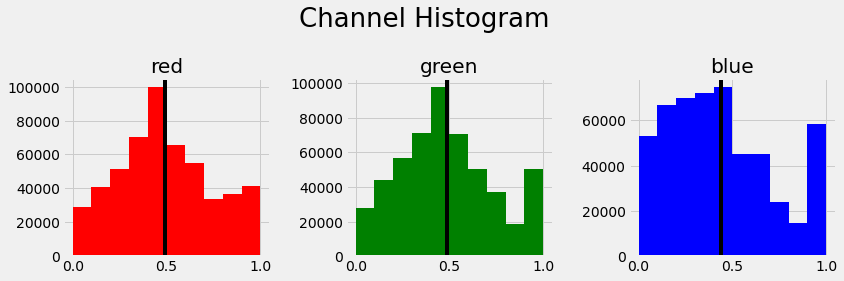

In [7]:
#
# Specify appropriate transforms, and batch_sizes and inspect data-distribution
#

batch_size = 32

# Load train data first 
train_ds = datasets.ImageFolder(root='landmark_images/train',
                                transform=transforms.Compose([
                                    transforms.Resize((128, 128)),
                                    transforms.CenterCrop(128),                                    
                                    transforms.RandomHorizontalFlip(p=0.25),
                                    transforms.ToTensor()]))
train_dl = DataLoader(train_ds, batch_size=batch_size)

# Compute mean and std for each channel
mean, std = get_mean_std(train_dl)
print(f'mean = {mean}')
print(f'std = {std}\n')

# Visualize RGB channel distribution
plot_channel_hist(train_dl)

In [4]:
#
# Normalize using the statistics obtained above and apply images augumentations. 
#
train_ds = datasets.ImageFolder(root='landmark_images/train',
                                transform=transforms.Compose([                                
                                    transforms.Resize((128, 128)),
                                    transforms.CenterCrop(128),                                    
                                    transforms.RandomHorizontalFlip(p=0.25),
                                    transforms.ToTensor(),                                    
                                    transforms.Normalize(mean, std)]))
classes = train_ds.classes
train_dl = DataLoader(train_ds, batch_size=batch_size)

#
# Compute mean and std after normalization
#
norm_mean, norm_std = get_mean_std(train_dl)
print(f'norm_mean = {norm_mean}')
print(f'norm_std = {norm_std}\n')

# Visualize RGB channel distribution after normalization
plot_channel_hist(train_dl)

In [9]:
# Preapare validation dataset, normalize it using the training statistics
val_ds = datasets.ImageFolder(root='landmark_images/val',
                              transform=transforms.Compose([
                              transforms.Resize((128, 128)),                                   
                              transforms.ToTensor(),
                              transforms.Normalize(mean, std)]))

In [10]:
# Preapare test dataset, normalize it using the training statistics
test_ds = datasets.ImageFolder(root='landmark_images/test',
                               transform=transforms.Compose([
                                   transforms.Resize((128, 128)),                                   
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)]))

In [11]:
print(f'train_size = {len(train_ds)}, val_size = {len(val_ds)}, test_size = {len(test_ds)}')

train_size = 3996, val_size = 1000, test_size = 1250


In [12]:
# Prepare dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size) 
loaders_scratch = {'train': train_dl, 'valid': val_dl, 'test': test_dl}

## Visualize a Batch of Training Data

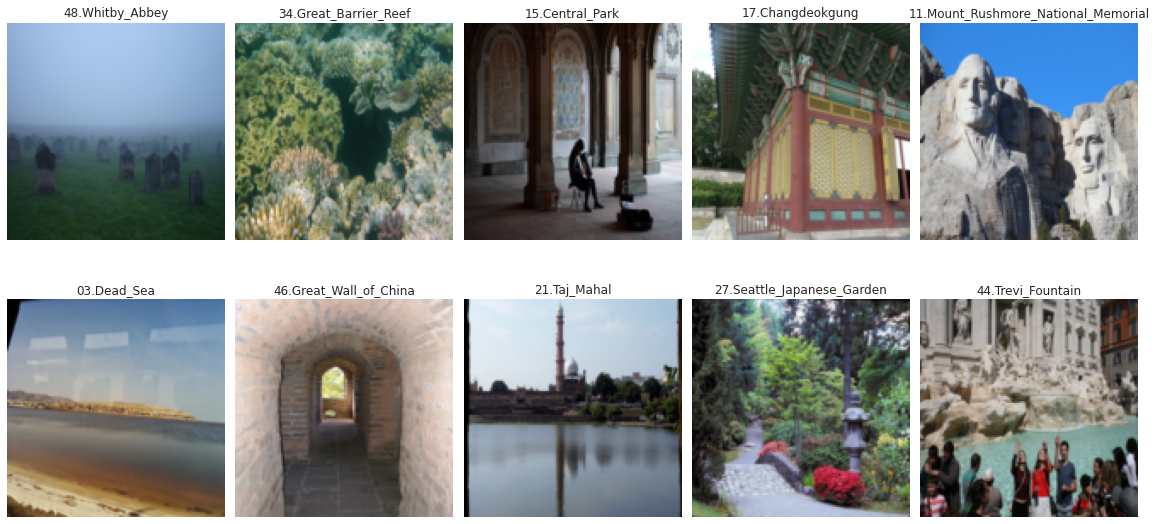

In [13]:
# Visualize a batch of the train data loader

def show_sample_images(dl, ds):
    batch = next(iter(dl))
    images, labels =  batch[0][:10], batch[1][:10]

    fig = plt.figure(figsize=(16, 8))
    fig.set_facecolor('white')
    plt.style.use('seaborn')
    for i, (image, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        image = image.permute(1, 2, 0)
        image = ((image * std) + mean).numpy().clip(0, 1)  # de-normalizing images for display
        ax.imshow(image)
        ax.set_title(classes[label.item()])
    plt.tight_layout()
    plt.show()
    
show_sample_images(train_dl, train_ds)

## Initialize use_cuda variable

In [14]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

## Specify Loss Function and Optimizer

In [15]:
# Select loss function
criterion_scratch = nn.NLLLoss()

# Select optimizer
def get_optimizer_scratch(model):
    #select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.001)

## Create a CNN to Classify Landmarks (from Scratch)

### Define the Network Architecture

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # Define layers of a CNN
        self.conv_1= nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu_1 = nn.ReLU(inplace=True)
        self.bn_1 = nn.BatchNorm2d(16)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2)        
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu_2 = nn.ReLU(inplace=True)
        self.bn_2 = nn.BatchNorm2d(32)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2)        
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu_3 = nn.ReLU(inplace=True) 
        self.bn_3 = nn.BatchNorm2d(64)        
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2)        
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu_4 = nn.ReLU(inplace=True)
        self.bn_4 = nn.BatchNorm2d(128)        
        self.maxpool_4 = nn.MaxPool2d(kernel_size=2)                
        self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu_5 = nn.ReLU(inplace=True)
        self.bn_5 = nn.BatchNorm2d(256)        
        self.maxpool_5 = nn.MaxPool2d(kernel_size=2)                        
        self.flatten_1 = nn.Flatten()
        self.linear_1 = nn.Linear(in_features=4 * 4 * 256, out_features=1024)
        self.relu_6 = nn.ReLU(inplace=True)
        self.bn_6 = nn.BatchNorm1d(1024)        
        self.linear_2 = nn.Linear(in_features=1024, out_features=50)
        self.output = nn.LogSoftmax(dim=1)
        
        ## Layers list
        self.layers = [layer for layer in self.modules() if not isinstance(layer, Net)]
      
    def forward(self, x):
        ## Define forward behavior
        for layer in self.layers: 
            x = layer(x)        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

### Train the network

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    loss_hist = {'train':[], 'val':[]} 

    for epoch in range(1, n_epochs+1):
        gc.collect()
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        start = time.time()
 
        #
        # Train the model
        #
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):        
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Compute the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion_scratch(output, target)
            optimizer.zero_grad()            
            loss.backward()
            
            optimizer.step()
            # Accumulate batch training loss
            train_loss += loss.detach().item() 
        # Epoch ends, Compute average training loss for this epoch                    
        else:                                    
            train_loss = train_loss / len(loaders['train'])
            loss_hist['train'].append(train_loss)

        #
        # Validate the model
        #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            #
            # Update average validation loss 
            #
            output = model(data)
            loss = criterion_scratch(output, target)
            # Accumulate batch validation loss
            valid_loss += loss.detach().item() 
        # Epoch ends, Compute average valiodation loss for this epoch
        else:                                   
            valid_loss = valid_loss / len(loaders['valid'])
            loss_hist['val'].append(valid_loss)
            
        end = time.time()   

        # Print training/validation statistics
        print('Epoch: {}/{} ({:.2f}s)\tTraining Loss: {:.16f} \tValidation Loss: {:.6f}'.format(
            epoch,
            n_epochs,
            end - start,
            train_loss,
            valid_loss
            ))
        
        # If the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print(f'val_loss decreased ({valid_loss_min:.6f}) --> ({valid_loss:.6f}), saving this model...')            
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
    # Plot the losses
    plt.plot(loss_hist['train'], label='Training')
    plt.plot(loss_hist['val'], label='Validation')
    plt.yscale('log')
    plt.legend()
    plt.show()
                
    return model

#### Train and validate the network with custom initial weight

Epoch: 1/15 (68.95s)	Training Loss: 3.7237954235076902 	Validation Loss: 3.346485
val_loss decreased (inf) --> (3.346485), saving this model...
Epoch: 2/15 (59.43s)	Training Loss: 3.0758460903167726 	Validation Loss: 2.961319
val_loss decreased (3.346485) --> (2.961319), saving this model...
Epoch: 3/15 (59.55s)	Training Loss: 2.6815448074340820 	Validation Loss: 2.946688
val_loss decreased (2.961319) --> (2.946688), saving this model...
Epoch: 4/15 (59.82s)	Training Loss: 2.2961492366790770 	Validation Loss: 2.884502
val_loss decreased (2.946688) --> (2.884502), saving this model...
Epoch: 5/15 (62.24s)	Training Loss: 2.0173293514251709 	Validation Loss: 2.729488
val_loss decreased (2.884502) --> (2.729488), saving this model...
Epoch: 6/15 (62.23s)	Training Loss: 1.7629106998443604 	Validation Loss: 2.898070
Epoch: 7/15 (58.69s)	Training Loss: 1.4991993207931518 	Validation Loss: 2.571203
val_loss decreased (2.729488) --> (2.571203), saving this model...
Epoch: 8/15 (60.67s)	Training

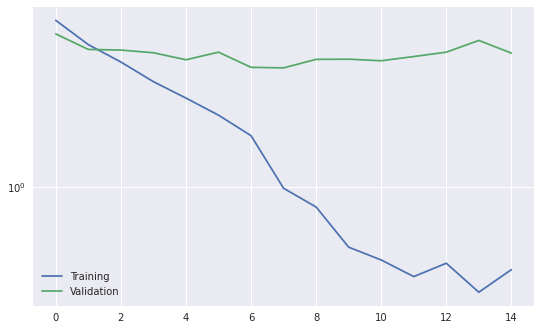

In [18]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    # Intiatize weights for Linear and Conv2D layers
    if classname.find('Linear') != -1:
        n_inputs =  m.in_features 
        y = 1/np.sqrt(n_inputs)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_scratch.apply(custom_weight_init)

model_scratch = train(15, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                     criterion_scratch, use_cuda, 'ignore.pt')

#### Train and Validate the network with Pytorch default initial weight

Epoch: 1/15 (89.40s)	Training Loss: 3.5572746982574461 	Validation Loss: 3.224763
val_loss decreased (inf) --> (3.224763), saving this model...
Epoch: 2/15 (60.89s)	Training Loss: 2.9893891544342042 	Validation Loss: 2.910336
val_loss decreased (3.224763) --> (2.910336), saving this model...
Epoch: 3/15 (59.34s)	Training Loss: 2.6118573360443116 	Validation Loss: 2.700395
val_loss decreased (2.910336) --> (2.700395), saving this model...
Epoch: 4/15 (58.87s)	Training Loss: 2.3451248445510866 	Validation Loss: 2.888847
Epoch: 5/15 (60.89s)	Training Loss: 2.1238015413284304 	Validation Loss: 2.482551
val_loss decreased (2.700395) --> (2.482551), saving this model...
Epoch: 6/15 (61.72s)	Training Loss: 1.7061192932128906 	Validation Loss: 2.529273
Epoch: 7/15 (60.99s)	Training Loss: 1.5147445263862609 	Validation Loss: 2.629399
Epoch: 8/15 (60.47s)	Training Loss: 1.3272888965606688 	Validation Loss: 2.768856
Epoch: 9/15 (60.33s)	Training Loss: 0.9766107969284058 	Validation Loss: 2.731531

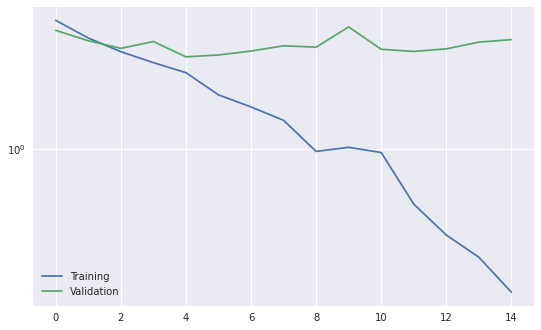

In [19]:
num_epochs = 15

# Function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### Test the Network

Evaluate the model on test dataset

In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        output = torch.exp(output)  # Get probability from LogSoftmax
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.439080


Test Accuracy: 38% (475/1250)


## Create a CNN to Classify Landmarks (using Transfer Learning)

In [21]:
# data loaders for training, validation, and test sets

loaders_transfer = {'train': None, 'valid': None, 'test': None}
loaders_transfer = loaders_scratch

# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### Specify Loss Function and Optimizer

In [22]:
criterion_transfer = nn.NLLLoss()

def get_optimizer_transfer(model):
    # Select and return optimizer
    # we only want our model classifier layer weights to change, rest remains frozen
    return optim.Adam(model.classifier.parameters(), lr=0.001)

### Define Network Architecture

Use transfer learning to create a CNN to classify images of landmarks.  

In [5]:
# Download the pretrained model
model_transfer = models.vgg19(pretrained=True)

# Freeze all model weights so that we do not changhe them when training
for param in model_transfer.parameters():
    param.require_grad = False
# Create a cutom classifier for our 50 classes and use it with pretrained model
clf = nn.Sequential(nn.Linear(in_features=25088, out_features=4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=4096, out_features=1024),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=1024, out_features=50),
                    nn.LogSoftmax(dim=1))
model_transfer.classifier = clf

if use_cuda:
    model_transfer = model_transfer.cuda()

### Train the Network

Epoch: 1/10 (96.29s)	Training Loss: 2.8921135358810424 	Validation Loss: 1.713286
val_loss decreased (inf) --> (1.713286), saving this model...
Epoch: 2/10 (96.48s)	Training Loss: 1.9697735214233398 	Validation Loss: 1.649083
val_loss decreased (1.713286) --> (1.649083), saving this model...
Epoch: 3/10 (97.60s)	Training Loss: 1.8068374261856079 	Validation Loss: 1.577479
val_loss decreased (1.649083) --> (1.577479), saving this model...
Epoch: 4/10 (95.24s)	Training Loss: 1.7753014030456542 	Validation Loss: 1.518231
val_loss decreased (1.577479) --> (1.518231), saving this model...
Epoch: 5/10 (96.50s)	Training Loss: 1.7085058207511903 	Validation Loss: 1.509380
val_loss decreased (1.518231) --> (1.509380), saving this model...
Epoch: 6/10 (97.81s)	Training Loss: 1.5706805577278138 	Validation Loss: 1.467943
val_loss decreased (1.509380) --> (1.467943), saving this model...
Epoch: 7/10 (97.83s)	Training Loss: 1.4722170290946961 	Validation Loss: 1.528529
Epoch: 8/10 (94.51s)	Training

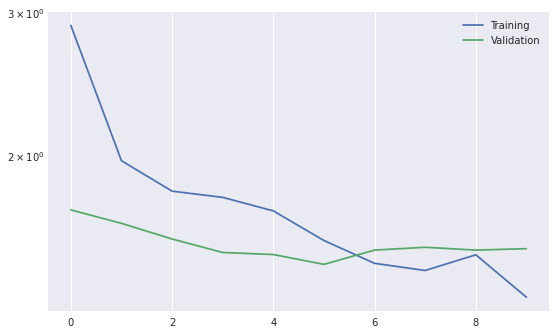

<All keys matched successfully>

In [24]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 10
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Network

Evaluate the model on test dataset

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.524580


Test Accuracy: 63% (788/1250)


## Define interface for inference 

In [26]:
import cv2
from PIL import Image

def predict_landmarks(img_path, k):
    #return the names of the top k landmarks predicted by the transfer learned CNN
    
    # Prepare image for model prediction
    img = Image.open(img_path)
    transform =  transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
    img = transform(img).unsqueeze(dim=0)
    
    # Load the best transfer-learning model that we trained
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    
    # Predict
    img = img.cuda()
    pred = model_transfer(img)     # LogSoftmax output
    pred_proba =  torch.exp(pred)  # Prediction probabilities
    _, labels =  torch.topk(pred_proba, k)
    labels = labels.cpu().numpy().squeeze()
    landmarks =  [classes[i] for i in labels]
    # Cleanup the labels
    landmarks = [' '.join(label[3:].split('_')) for label in landmarks]
    
    return landmarks
    
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Brooklyn Bridge',
 'Niagara Falls']

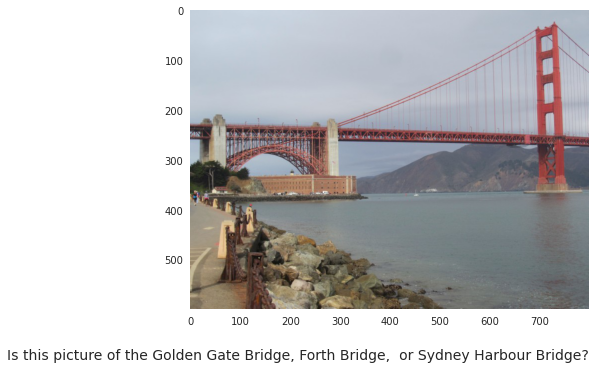

In [27]:
def suggest_locations(img_path):
    # get landmark predictions
    k = 3
    predicted_landmarks = predict_landmarks(img_path, k)
    
    #display image and display landmark predictions
    img = Image.open(img_path)    
    plt.imshow(img)
    plt.grid(None)
    
    desc = ''
    for i in range(k-1):
        desc += predicted_landmarks[i] + ', '
    desc +=  ' or ' + predicted_landmarks[-1] + '?'
    desc = 'Is this picture of the ' + desc
    plt.title(desc, x = 1, y=-0.15, pad=-5, fontdict={'fontsize': 14, 'horizontalalignment': 'right'})
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### More testing

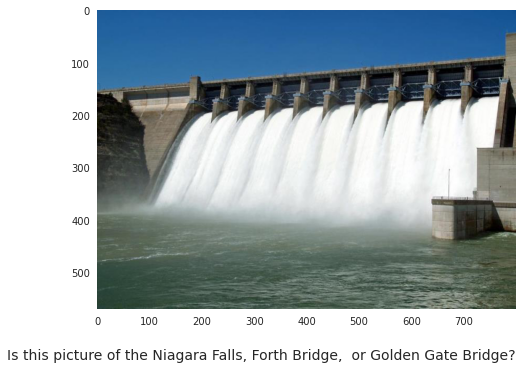

In [29]:
# test on a sample image1
suggest_locations('images/bhakra-dam.jpg')

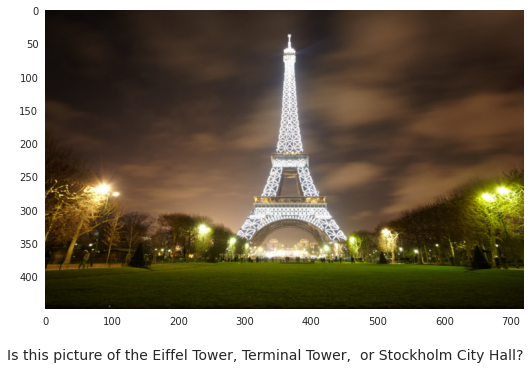

In [30]:
# test on a sample image2
suggest_locations('images/Eiffel-tower_night.jpg')

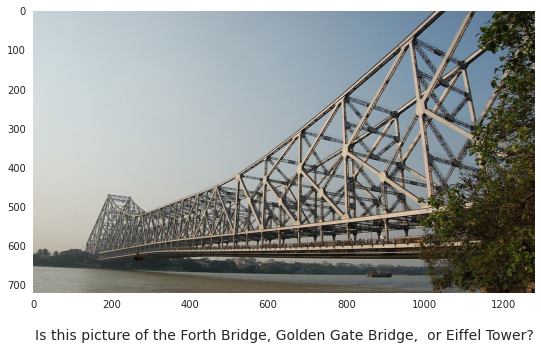

In [31]:
# test on a sample image3
suggest_locations('images/Howrah-Bridge.jpg')

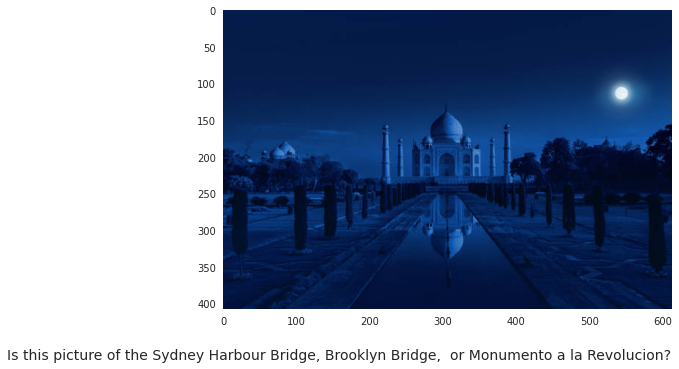

In [32]:
# test on a sample image4
suggest_locations('images/taj-mahal-at-full-moon-night.jpg')